## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')

# Modules needed for Linear Regression, testing and Evaluation
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import LassoCV

## Reading in data

In [2]:
# reading the data into a data frame variable master
train_data = pd.read_csv('./datasets/train.csv')

In [3]:
train_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
train_data.shape

(2051, 81)

## Exploratory Data Analysis

### Target Variable Analysis

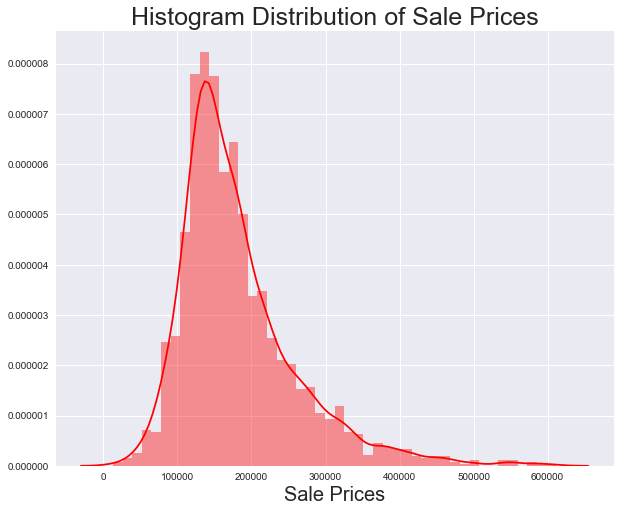

In [5]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['SalePrice']], color='red');
plt.title("Histogram Distribution of Sale Prices", fontsize = 25)
plt.xlabel("Sale Prices", fontsize = 20);

* The distribution of sale prices in Ames has a right skew. Meaning that there are a few houses that has an extreme price compared to the rest of the data. 
* Because this column is our target varible, it is best to log transform this column to create a more normal distribution. This will allow us a better target to predict towards. 

In [6]:
# Log transforming SalePrice Column 
train_data['log_SalePrice'] = train_data['SalePrice'].apply(np.log)

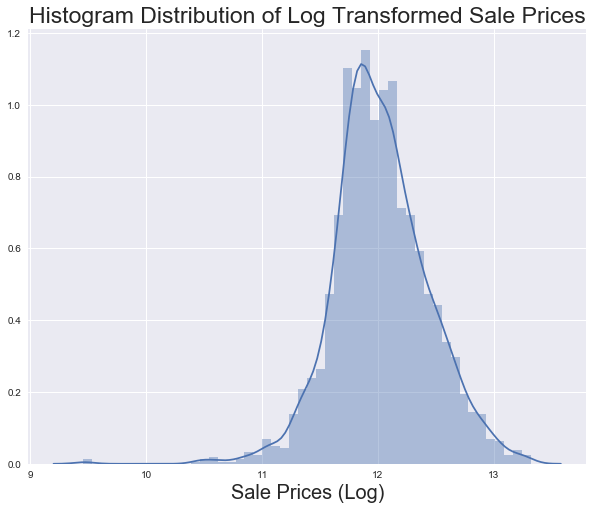

In [7]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['log_SalePrice']]);
plt.title("Histogram Distribution of Log Transformed Sale Prices", fontsize = 23)
plt.xlabel("Sale Prices (Log)", fontsize = 20);

* Though our distribution becomes more normal there appears to be a tail to the left, which may indicate that we have some outliers in our data. 

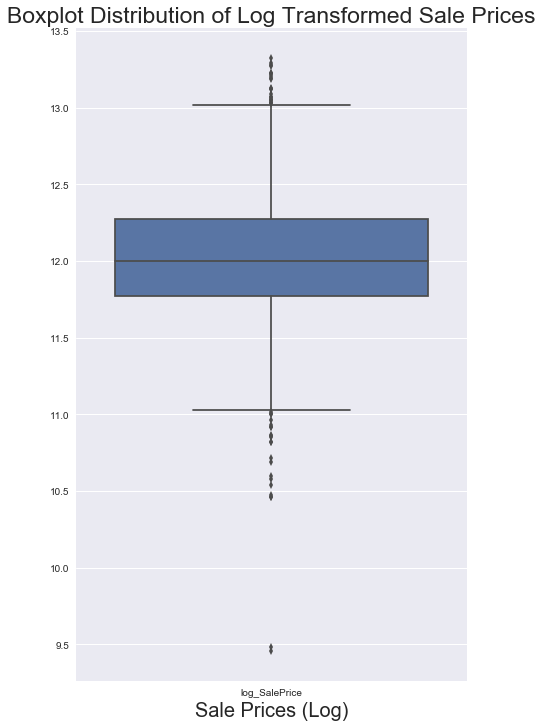

In [8]:
plt.figure(figsize=(7, 12))
sns.boxplot(data=train_data[['log_SalePrice']])
plt.title("Boxplot Distribution of Log Transformed Sale Prices", fontsize = 23)
plt.xlabel("Sale Prices (Log)", fontsize = 20);

In [9]:
train_data['log_SalePrice'].sort_values()

1628     9.456341
183      9.480368
1309    10.460242
1292    10.463103
1518    10.471950
          ...    
151     13.229568
1796    13.275828
1692    13.278512
1964    13.290564
1671    13.323927
Name: log_SalePrice, Length: 2051, dtype: float64

* There appears there 2 significant outliers on the chart (ID 1628 & 183). These are candidates to be excluded from our model training data. 

In [10]:
train_data[['Id','Lot Area','SalePrice']].sort_values(by='SalePrice')

,Id,Lot Area,SalePrice
1628,182,9656,12789
183,1554,14584,13100
1309,727,7879,34900
1292,2844,8088,35000
1518,2881,9000,35311
...,...,...,...
151,2333,16056,556581
1796,434,13891,582933
1692,2451,17242,584500
1964,1638,51974,591587


* These two houses have extremely low prices in comparison to other houses in our data set. I will filtered these out.

In [11]:
train_data = train_data[train_data['SalePrice'] > 13_100]

In [12]:
train_data.shape

(2049, 82)

* After the outliers being removed there is 2 less rows.

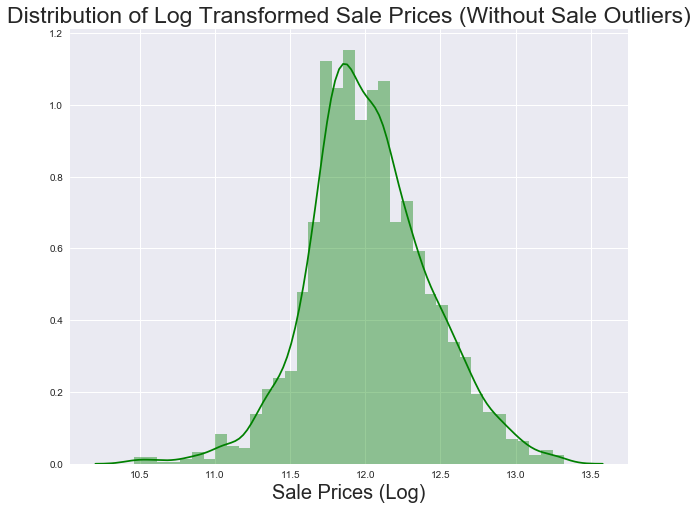

In [13]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['log_SalePrice']], color='green');
plt.title("Distribution of Log Transformed Sale Prices (Without Sale Outliers)", fontsize = 23)
plt.xlabel("Sale Prices (Log)", fontsize = 20);

* After the removal of the two outliers, we now have a normal distribution for our target variable. Log of Sale Prices.

In [14]:
# Moving to evaluating the train data set further. 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 82 columns):
Id                 2049 non-null int64
PID                2049 non-null int64
MS SubClass        2049 non-null int64
MS Zoning          2049 non-null object
Lot Frontage       1719 non-null float64
Lot Area           2049 non-null int64
Street             2049 non-null object
Alley              140 non-null object
Lot Shape          2049 non-null object
Land Contour       2049 non-null object
Utilities          2049 non-null object
Lot Config         2049 non-null object
Land Slope         2049 non-null object
Neighborhood       2049 non-null object
Condition 1        2049 non-null object
Condition 2        2049 non-null object
Bldg Type          2049 non-null object
House Style        2049 non-null object
Overall Qual       2049 non-null int64
Overall Cond       2049 non-null int64
Year Built         2049 non-null int64
Year Remod/Add     2049 non-null int64
Roof Style         20

* Our overall data frame appears to have several columns with null values. 
* There are 11 float, 28 integer, & 42 object columns.

### Null Value Analysis

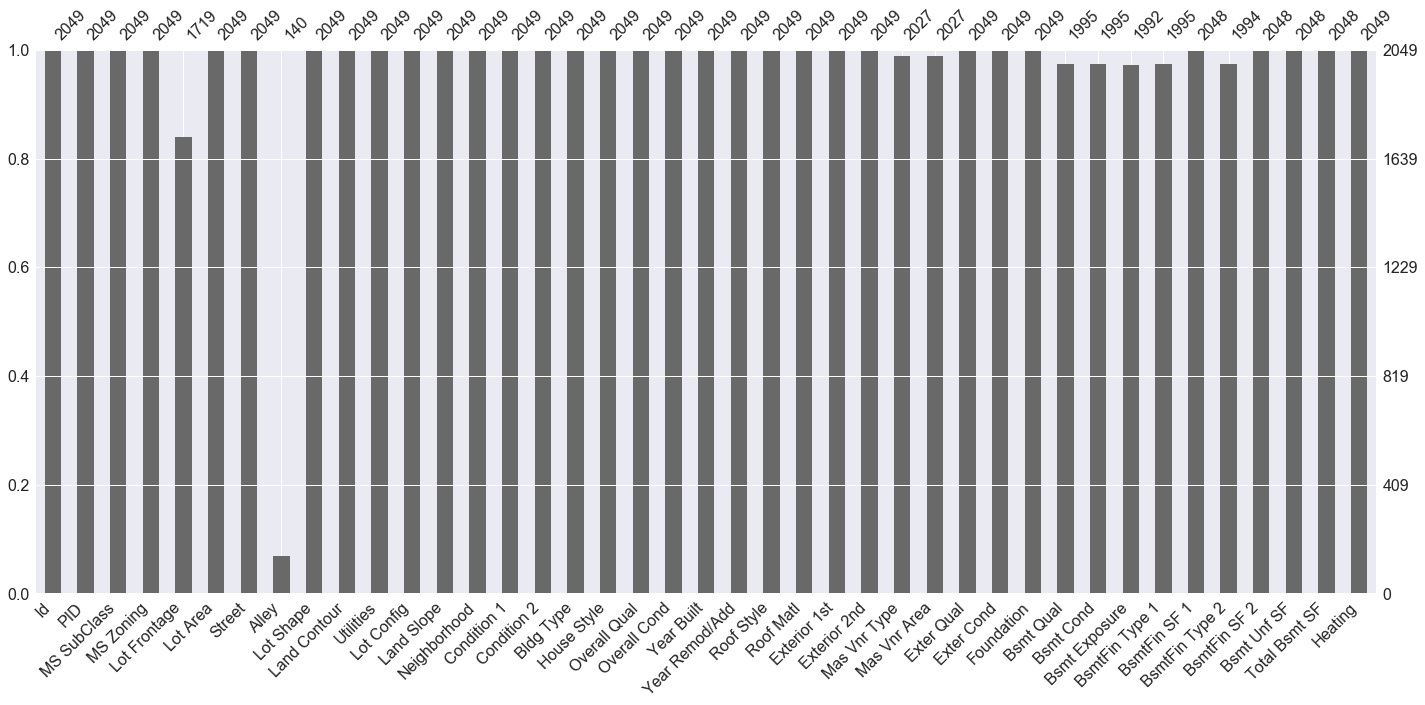

In [15]:
# First half of the columns in the training data set. Viewing the columns with missing values.
msno.bar(train_data.iloc[:,0:41]);

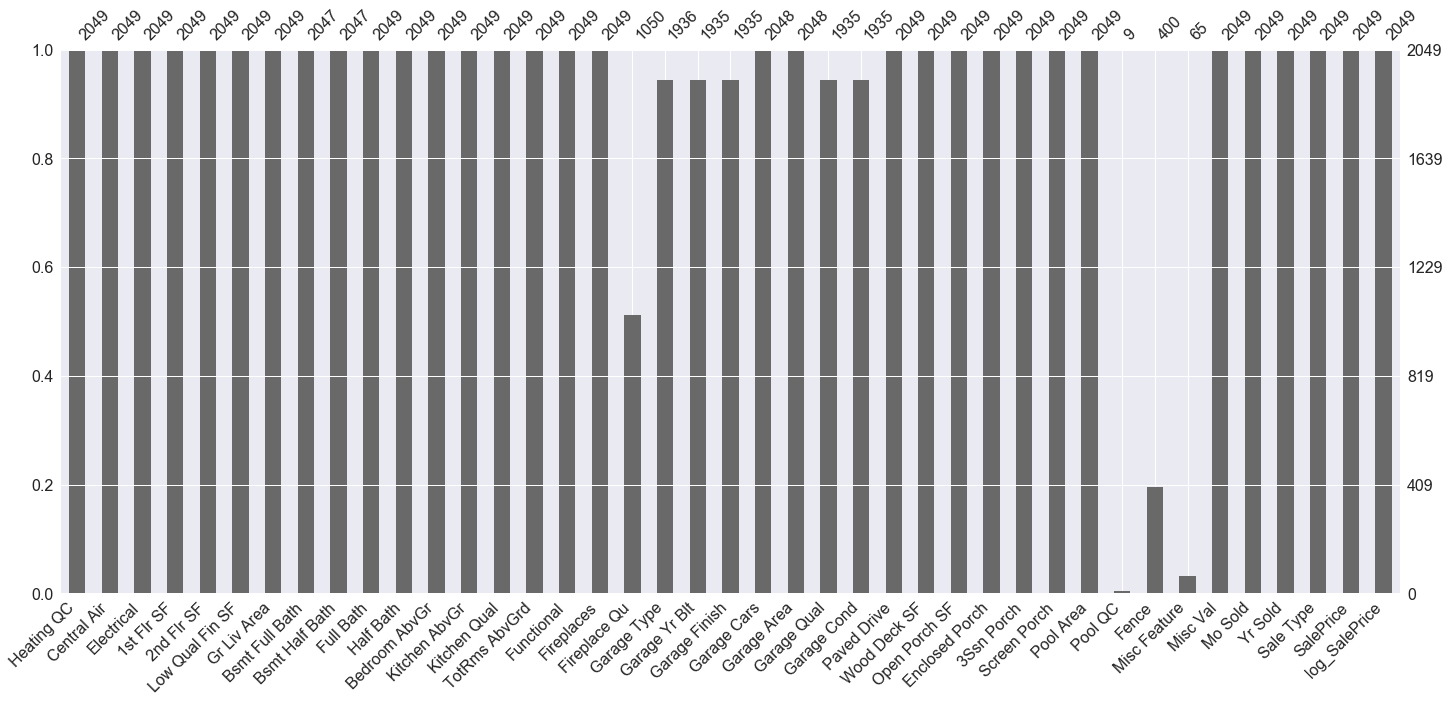

In [16]:
# Second half of the columns in the training data set. Viewing the columns with missing values.
msno.bar(train_data.iloc[:,41:]);

In [17]:
# Displaying the proportion of null values in each column
train_data.isnull().mean().sort_values(ascending = False).head(26)

Pool QC           0.995608
Misc Feature      0.968277
Alley             0.931674
Fence             0.804783
Fireplace Qu      0.487555
Lot Frontage      0.161054
Garage Cond       0.055637
Garage Finish     0.055637
Garage Yr Blt     0.055637
Garage Qual       0.055637
Garage Type       0.055149
Bsmt Exposure     0.027818
BsmtFin Type 2    0.026842
Bsmt Cond         0.026354
Bsmt Qual         0.026354
BsmtFin Type 1    0.026354
Mas Vnr Type      0.010737
Mas Vnr Area      0.010737
Bsmt Half Bath    0.000976
Bsmt Full Bath    0.000976
Garage Cars       0.000488
Garage Area       0.000488
Total Bsmt SF     0.000488
Bsmt Unf SF       0.000488
BsmtFin SF 2      0.000488
BsmtFin SF 1      0.000488
dtype: float64

* There are 26 columns that have null values. 
* From these columns there are 5 columns that have approximately 50% or more missing values.

### Variables of Interest

In [18]:
# Calling the describe method to get a bigger picture of my numerical columns in the dataset.
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2049.0,1.474625e+03,8.439080e+02,1.000000e+00,7.540000e+02,1.486000e+03,2.199000e+03,2.930000e+03
PID,2049.0,7.134020e+08,1.886878e+08,5.263011e+08,5.284581e+08,5.354532e+08,9.071800e+08,9.241520e+08
MS SubClass,2049.0,5.704002e+01,4.283315e+01,2.000000e+01,2.000000e+01,5.000000e+01,7.000000e+01,1.900000e+02
Lot Frontage,1719.0,6.904945e+01,2.327268e+01,2.100000e+01,5.800000e+01,6.800000e+01,8.000000e+01,3.130000e+02
Lot Area,2049.0,1.006320e+04,6.745035e+03,1.300000e+03,7.500000e+03,9.405000e+03,1.151200e+04,1.590000e+05
Overall Qual,2049.0,6.116642e+00,1.419576e+00,1.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,1.000000e+01
Overall Cond,2049.0,5.564178e+00,1.102158e+00,1.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00
Year Built,2049.0,1.971742e+03,3.017027e+01,1.872000e+03,1.954000e+03,1.974000e+03,2.001000e+03,2.010000e+03
Year Remod/Add,2049.0,1.984213e+03,2.103215e+01,1.950000e+03,1.965000e+03,1.993000e+03,2.004000e+03,2.010000e+03
Mas Vnr Area,2027.0,9.979428e+01,1.750214e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.615000e+02,1.600000e+03


#### Age of Home

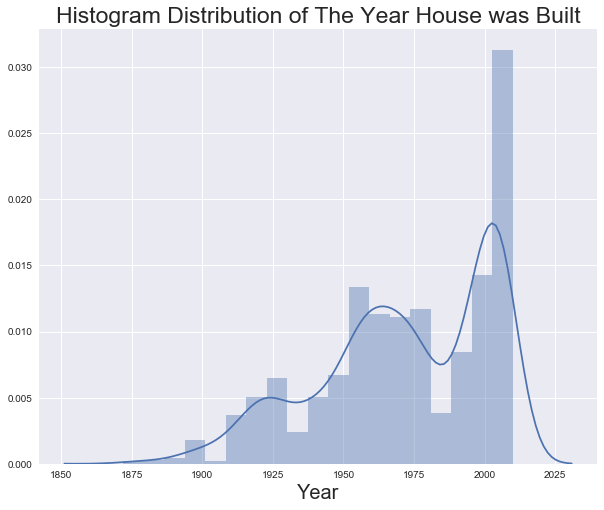

In [19]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['Year Built']]);
plt.title("Histogram Distribution of The Year House was Built", fontsize = 23)
plt.xlabel("Year", fontsize = 20);

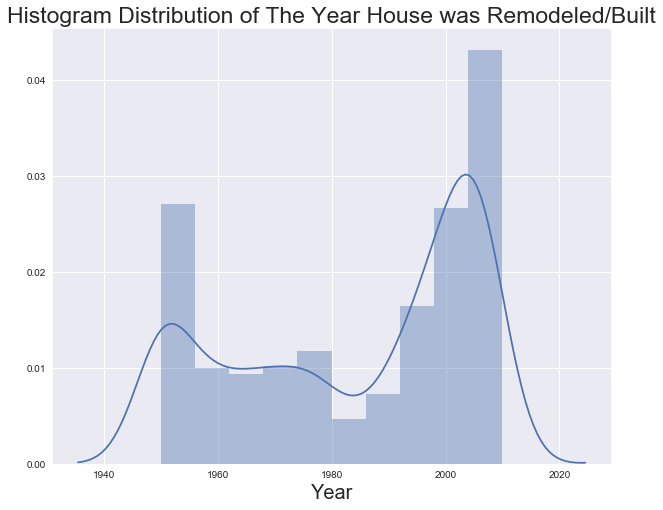

In [20]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['Year Remod/Add']]);
plt.title("Histogram Distribution of The Year House was Remodeled/Built", fontsize = 23)
plt.xlabel("Year", fontsize = 20);

* The two initial numerical variables that I am interested in are: 
    - Year Built
    - Year Remod/Add
* These two columns reflect on how new the house is, which is something that I belive home purchasers factor heavily.
* I will engineer these two columns to reflect the actual age of the house.

In [21]:
# adding two new columns to the data frame to reflect the age of the house. This is performed by subtracting the year from the current year.
train_data['age'] = 2019 - train_data['Year Built']
train_data['Remodel age'] = 2019 - train_data['Year Remod/Add']

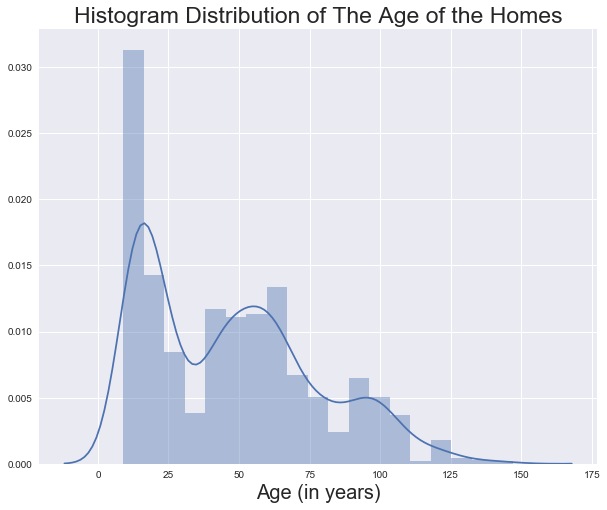

In [22]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['age']]);
plt.title("Histogram Distribution of The Age of the Homes", fontsize = 23)
plt.xlabel("Age (in years)", fontsize = 20);

* The distributon of the columns are now flipped. The x-axis goes from reflecting year built to age in years, which has the new home (little to no years) on the beginning of the axis.

### Variables of interest (With Nulls)

In [23]:
train_data['Garage Cars'].fillna(0, inplace=True)
train_data['Garage Area'].fillna(0, inplace=True)

* The Garage Cars & Area variable only had one cell with a missing value, so I just filled it with 0. I believe these two columns will be important predictors so I want to have a full data set to use in my model.

In [24]:
# Filling null observation with 0 for each Basement variable.
train_data['Total Bsmt SF'].fillna(0, inplace = True)
train_data['BsmtFin SF 1'].fillna(0, inplace = True)
train_data['BsmtFin SF 2'].fillna(0, inplace = True)
train_data['Bsmt Unf SF'].fillna(0, inplace = True)

* I have also filled the nulls of 4 Basement columns that I believe will be good predictors of Sales price(log).

### Log Transfrom Variable Candidates

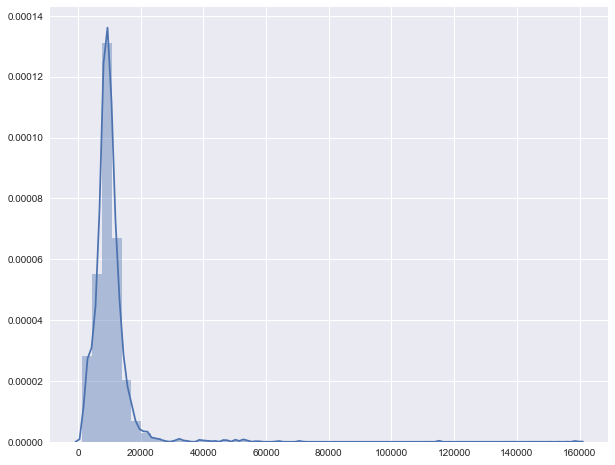

In [25]:
# train_data['Lot Area'].hist()
plt.figure(figsize=(10,8))
sns.distplot(train_data[['Lot Area']]);

* lot area's distribution is very skewed to the right. Would like to log transform the data to see if it normalizes better.

In [26]:
# Log transforming Lot Area Column
train_data['log_Lot Area'] = train_data['Lot Area'].apply(np.log)

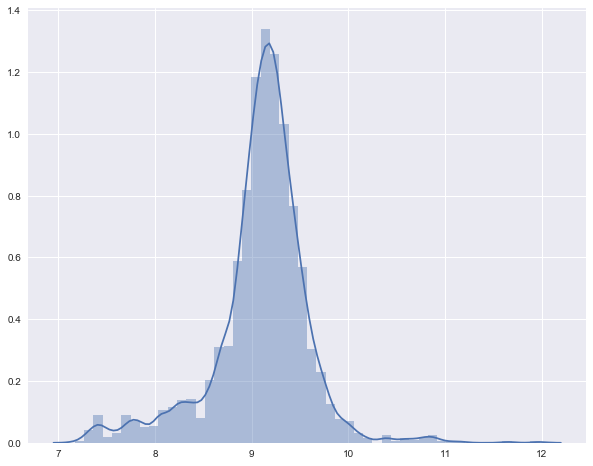

In [27]:
# train_data['log_Lot Area'].hist()
plt.figure(figsize=(10,8))
sns.distplot(train_data[['log_Lot Area']]);

* After Log transforming the Lot Area column, the data is closer to a normal distribution. 

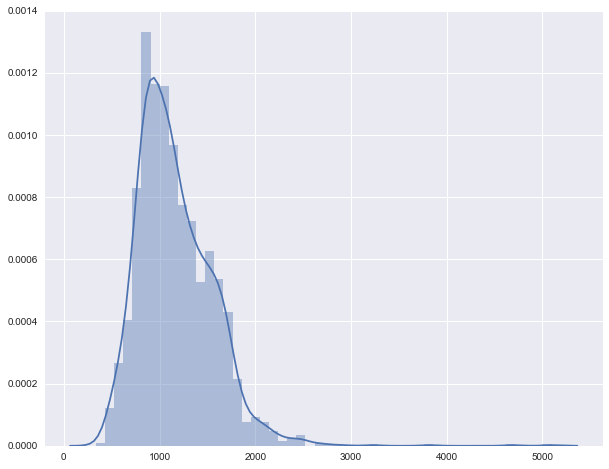

In [28]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['1st Flr SF']]);

* 1st Floor Surface area's distribution is slightly skewed to the right. Would like to log transform the data to see if it normalizes better.

In [29]:
# Log transforming 1st Floor Column
train_data['log_1st Flr SF'] = train_data['1st Flr SF'].apply(np.log)

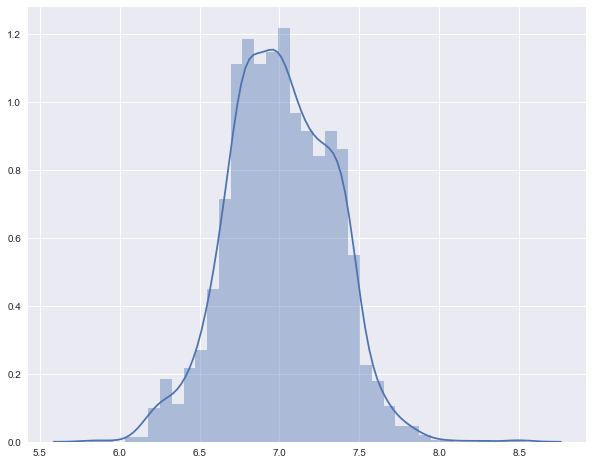

In [30]:
plt.figure(figsize=(10,8))
sns.distplot(train_data[['log_1st Flr SF']]);

* After Log transforming the 1st Floor Surface area column, the data is closer to a normal distribution. 

### Ordinal Variables of Interest

In [31]:
train_data['Kitchen Qual'].value_counts()

TA    1046
Gd     806
Ex     151
Fa      46
Name: Kitchen Qual, dtype: int64

In [32]:
train_data['Kitchen Qual'] = train_data['Kitchen Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [33]:
train_data['Exter Qual'] = train_data['Exter Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [34]:
train_data['Exter Cond'] = train_data['Exter Cond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [35]:
train_data['Heating QC'] = train_data['Heating QC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

* For each of the ordinal columns of interest. I have decided to map integers from 1 to 5, with 1 representing poor and 5 representing excellent to it's corresponding category. The variables this is applied to is: 
    - Kitchen Quality
    - Exterior Quality
    - Exterior Condition
    - Heating Quality.

In [36]:
train_data['Heating'].value_counts()

GasA    2017
GasW      20
Grav       5
Wall       5
OthW       2
Name: Heating, dtype: int64

In [37]:
train_data['Heating'] = [1 if i == 'GasA' else 0 for i in train_data['Heating']]

* The Heating column has majority of it's values in GasA so I will binorize this column with 1 if value is GasA & 0 for everything else.

### Categorical Variables of Interest

In [38]:
# Recatergorizing Group to the majority of the data and minority binned to other
train_data['Bldg Type'] = train_data['Bldg Type'].map(lambda Bldg: '1Fam' if Bldg == '1Fam' else ('TwnhsE' if Bldg == 'TwnhsE' else 'Other'))
train_data['Bldg Type'].value_counts('mean')

1Fam      0.828697
Other     0.092728
TwnhsE    0.078575
Name: Bldg Type, dtype: float64

In [39]:
train_data['House Style'].value_counts('mean')

1Story    0.515861
2Story    0.291850
1.5Fin    0.106393
SLvl      0.045876
SFoyer    0.024402
2.5Unf    0.006833
1.5Unf    0.005857
2.5Fin    0.002928
Name: House Style, dtype: float64

In [40]:
# Recatergorizing
train_data['House Style'] = train_data['House Style'].map(lambda house: '1Story' if house == '1Story' else ('2Story' if house == '2Story' else ('1.5Fin' if house == '1.5Fin' else 'Other')))
train_data['House Style'].value_counts('mean')

1Story    0.515861
2Story    0.291850
1.5Fin    0.106393
Other     0.085896
Name: House Style, dtype: float64

In [41]:
train_data['MS Zoning'].value_counts('mean')

RL         0.779893
RM         0.153734
FV         0.049292
C (all)    0.009273
RH         0.006833
I (all)    0.000488
A (agr)    0.000488
Name: MS Zoning, dtype: float64

In [42]:
# Recatergorizing
train_data['MS Zoning'] = train_data['MS Zoning'].map(lambda zone: 'RL' if zone == 'RL' else ('RM' if zone == 'RM' else ('FV' if zone == 'FV' else 'Other')))
train_data['MS Zoning'].value_counts('mean')

RL       0.779893
RM       0.153734
FV       0.049292
Other    0.017082
Name: MS Zoning, dtype: float64

In [43]:
train_data['Neighborhood'].value_counts('mean')

NAmes      0.151293
CollgCr    0.087848
OldTown    0.079063
Edwards    0.069790
Somerst    0.063446
NridgHt    0.059541
Gilbert    0.056613
Sawyer     0.054173
NWAmes     0.042460
SawyerW    0.042460
Mitchel    0.040020
BrkSide    0.037091
Crawfor    0.034651
IDOTRR     0.033187
NoRidge    0.023426
Timber     0.023426
StoneBr    0.018546
SWISU      0.015617
ClearCr    0.013177
MeadowV    0.011713
Blmngtn    0.010737
BrDale     0.009273
Veenker    0.008297
NPkVill    0.008297
Blueste    0.002928
Greens     0.001464
GrnHill    0.000976
Landmrk    0.000488
Name: Neighborhood, dtype: float64

In [44]:
train_data['Neighborhood'] = train_data['Neighborhood'].map(lambda hood: 'CollgCr' if hood == 'CollgCr' else ('OldTown' if hood == 'OldTown' else ('Edwards' if hood == 'Edwards' else ('Somerst' if hood == 'Somerst' else ('NoRidge' if hood == 'NoRidge' else ('IDOTRR' if hood == 'IDOTRR' else ('StoneBr' if hood == 'StoneBr' else ('NridgHt' if hood == 'NridgHt' else 'Other'))))))))
train_data['Neighborhood'].value_counts('mean')

Other      0.565154
CollgCr    0.087848
OldTown    0.079063
Edwards    0.069790
Somerst    0.063446
NridgHt    0.059541
IDOTRR     0.033187
NoRidge    0.023426
StoneBr    0.018546
Name: Neighborhood, dtype: float64

* Recategorized 4 categorical variables of interest prior to creating dummies for modeling.

In [45]:
train_data = pd.get_dummies(train_data, 
                          columns=['Bldg Type','House Style','MS Zoning','Neighborhood'], 
                          drop_first=True
                         )

### Predictor Selection
#### Correlation Review

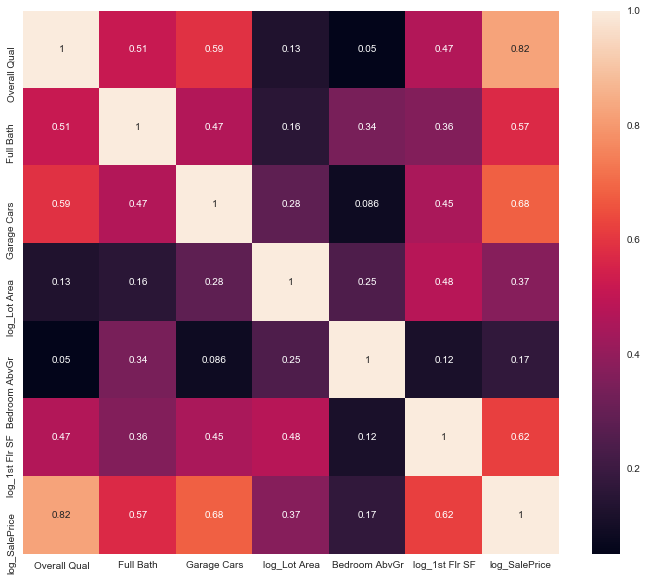

In [46]:
interesting_cols = ['Overall Qual', 'Full Bath', 'Garage Cars','log_Lot Area','Bedroom AbvGr','log_1st Flr SF','log_SalePrice']
plt.figure(figsize=(12,10))
hm = sns.heatmap(train_data[interesting_cols].corr(), annot=True)

### Initial Model

In [47]:
corr = train_data[interesting_cols]
X = corr.drop(columns='log_SalePrice')
y = train_data['log_SalePrice']

**Train Test Split**

In [48]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=8)

In [49]:
X_train.shape

(1536, 6)

In [50]:
y_train.shape

(1536,)

In [51]:
X_train.columns

Index(['Overall Qual', 'Full Bath', 'Garage Cars', 'log_Lot Area',
       'Bedroom AbvGr', 'log_1st Flr SF'],
      dtype='object')

**Intantiate & Fit**

In [52]:
mlr = LinearRegression()

In [53]:
mlr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Score Model: Metrics**

In [54]:
# Training Score
mlr.score(X_train, y_train)

0.8065879397771365

In [55]:
# Holdout Score
mlr.score(X_holdout, y_holdout)

0.8185466953904792

In [56]:
cross_val_score(mlr, X_train, y_train, cv=10).mean() #Vector of running the model several times with different splits.

0.8017610750010542

In [57]:
# A:
def regress_metrics(y, y_hat, n, k):
    # Mean absolute Error calc
    ye = np.exp(y)
    y_hate = np.exp(y_hat)
    mae = metrics.mean_absolute_error(ye, y_hate)
    
    # Residual Sum of Squares calc
    rss = np.sum((ye-y_hate)**2)
    
    # Mean Squared Error calc
    
    mse = metrics.mean_squared_error(ye, y_hate)
    
    # Root Mean Squared Error calc
    rmse = np.sqrt(mse)
    
    # R squared calc
    R2 = metrics.r2_score(y, y_hat)
    
    # Adjusted R squared calc
    factor = (1 - R2)*(n-1) / (n - k - 1)
    R2_adj = 1 - factor
    
    
    return {'MAE': mae, 'RSS': rss, 'MSE': mse, 'RMSE': rmse, 'R_Squared': R2, 'Adjusted R_Squred': R2_adj}

In [58]:
# Training Data Metrics
ln_preds = mlr.predict(X_train)
preds = ln_preds
y_train = y_train
n = len(preds)
k = len(X_train)

regress_metrics(y_train, preds, n, k)

{'MAE': 22862.720855702977,
 'RSS': 1783204110979.7551,
 'MSE': 1160940176.4191115,
 'RMSE': 34072.5722013926,
 'R_Squared': 0.8065879397771365,
 'Adjusted R_Squred': 297.8875124420955}

In [59]:
preds = mlr.predict(X_train)

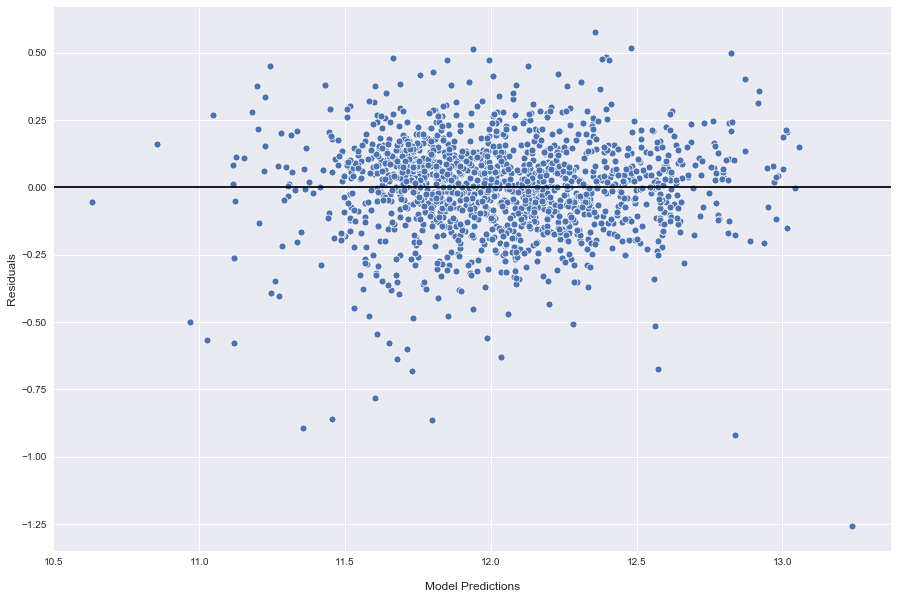

In [60]:
resids = y_train - preds
plt.figure(figsize=(15,10))
sns.scatterplot(preds, resids)
plt.axhline(0, color="black");
plt.ylabel("Residuals", fontsize = 12)
plt.xlabel("Model Predictions", fontsize = 12, labelpad= 15);

### Second Model

In [61]:
interest = ['log_SalePrice','Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Full Bath', 'log_Lot Area', 'TotRms AbvGrd', 'Fireplaces','2nd Flr SF','log_1st Flr SF','MS Zoning_Other', 'MS Zoning_RL', 'MS Zoning_RM',
       'age', 'Garage Area', 'Remodel age', 'Neighborhood_Edwards',
       'Neighborhood_IDOTRR', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_Other', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr','Total Bsmt SF','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF']

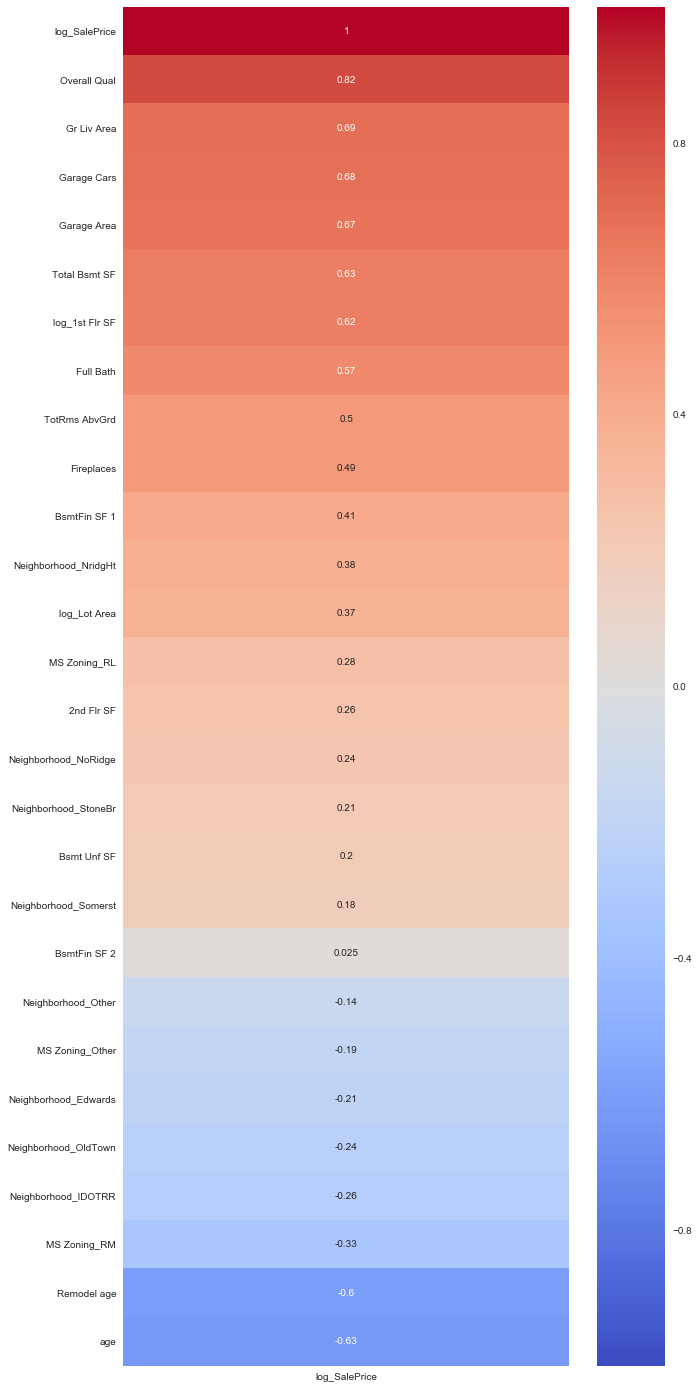

In [62]:
corr_eval = train_data[interest]
# plt.title("Heatmap Showing Correlations between Predictors & Log Sale Price", fontsize = 23)
plt.figure(figsize=(10,25))
sns.heatmap(corr_eval.corr()[['log_SalePrice']].sort_values('log_SalePrice', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

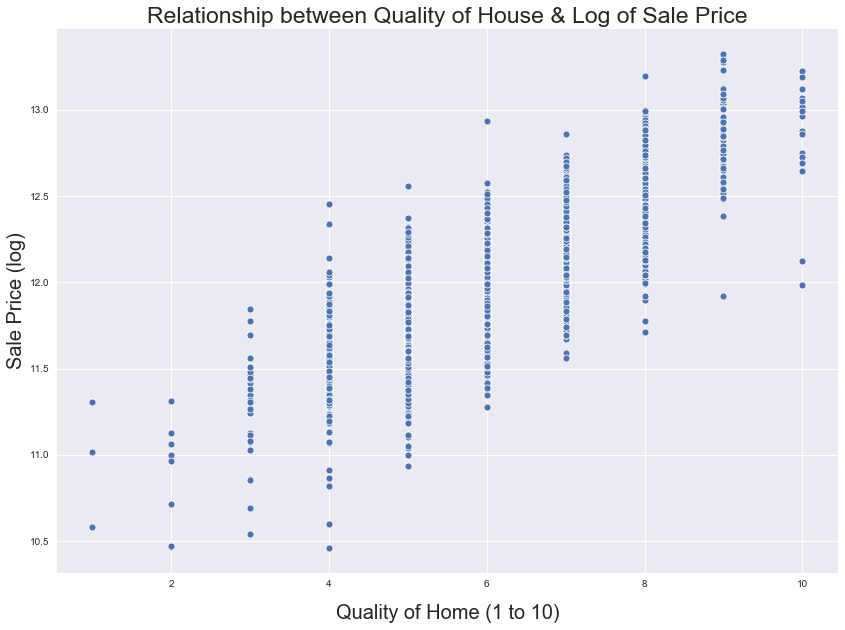

In [63]:
plt.figure(figsize=(14,10))
sns.scatterplot(train_data['Overall Qual'],train_data['log_SalePrice'])
plt.title("Relationship between Quality of House & Log of Sale Price", fontsize = 23)
plt.ylabel("Sale Price (log)", fontsize = 20)
plt.xlabel("Quality of Home (1 to 10)", fontsize = 20, labelpad= 15);

In [64]:
X = corr_eval.drop(columns='log_SalePrice')
y = train_data['log_SalePrice']

**Train Test Split**

In [65]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=8)

**Intantiate & Fit**

In [66]:
mlr = LinearRegression()

In [67]:
mlr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Score Model: Metrics (2nd Model)**

In [68]:
# Training Score
mlr.score(X_train, y_train)

0.8800737025648769

In [69]:
# Holdout Score
mlr.score(X_holdout, y_holdout)

0.8994007356312638

In [70]:
cross_val_score(mlr, X_train, y_train, cv=10).mean() #Vector of running the model several times with different splits.

0.8585453883578573

In [71]:
# Training Data Metrics
ln_preds = mlr.predict(X_train)
preds = ln_preds
y_train = y_train
n = len(preds)
k = len(X_train)

regress_metrics(y_train, preds, n, k)

{'MAE': 17006.078352241322,
 'RSS': 1439020355400.3496,
 'MSE': 936862210.5471026,
 'RMSE': 30608.204954670284,
 'R_Squared': 0.8800737025648769,
 'Adjusted R_Squred': 185.0868665629139}

In [72]:
preds = mlr.predict(X_train)

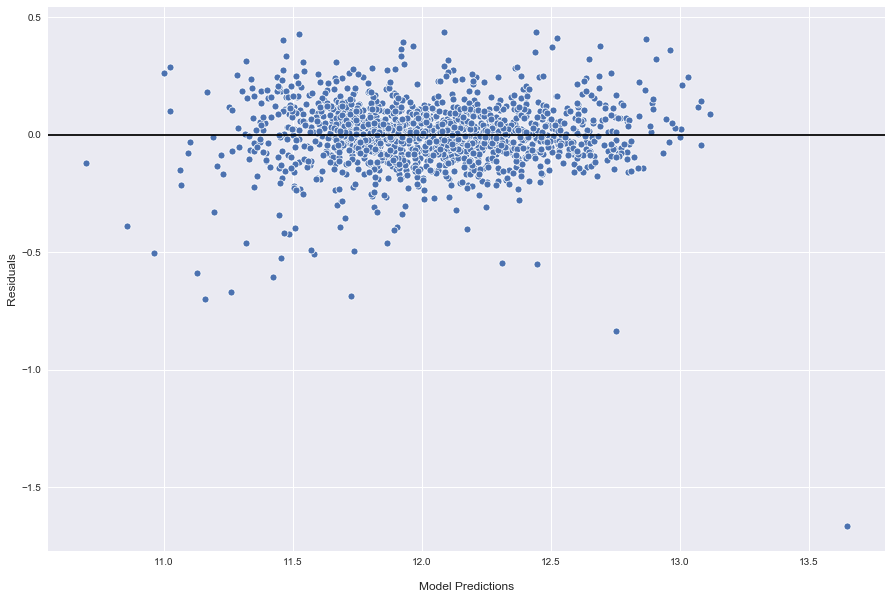

In [73]:
resids = y_train - preds
plt.figure(figsize=(15,10))
sns.scatterplot(preds, resids)
plt.axhline(0, color="black");
plt.ylabel("Residuals", fontsize = 12)
plt.xlabel("Model Predictions", fontsize = 12, labelpad= 15);

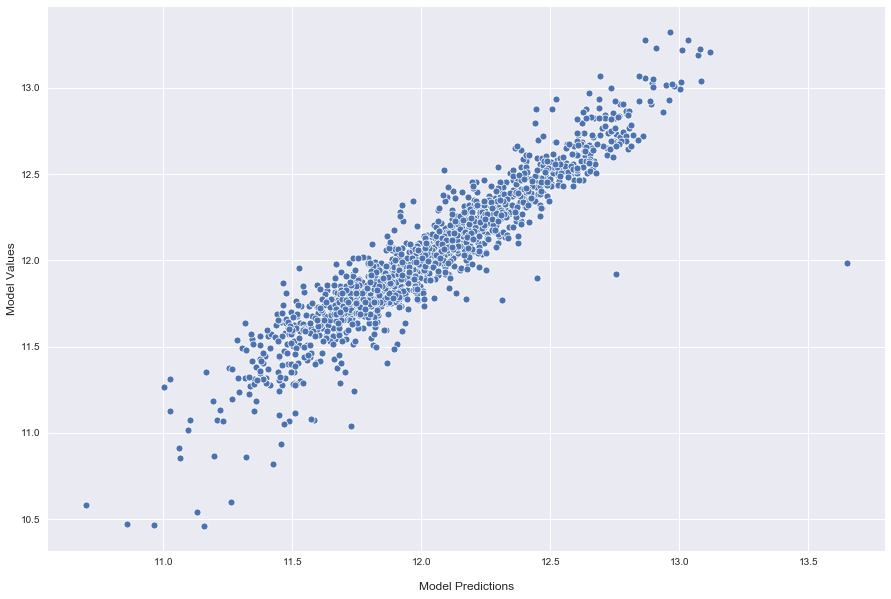

In [74]:
plt.figure(figsize=(15,10))
sns.scatterplot(ln_preds, y_train)
# plt.axhline(0, color="black");
plt.ylabel("Model Values", fontsize = 12)
plt.xlabel("Model Predictions", fontsize = 12, labelpad= 15);

### Final Model

**Lasso Model with Polynomial Interaction Features**

In [75]:
poly_interest = ['log_SalePrice','Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Full Bath', 'log_Lot Area', 'TotRms AbvGrd', 'Fireplaces','2nd Flr SF','log_1st Flr SF','age', 'Garage Area', 'Remodel age','Total Bsmt SF','BsmtFin SF 1','Bsmt Unf SF','Kitchen Qual','Exter Qual','Heating QC']

In [76]:
# Poly Test Data Set
poly_test = train_data[poly_interest]
poly_test.shape

(2049, 19)

In [77]:
X = poly_test.drop(columns=['log_SalePrice'])

In [78]:
features = X.columns

In [79]:
y = poly_test['log_SalePrice']

In [80]:
poly = PolynomialFeatures(include_bias=False)

In [81]:
X_poly = poly.fit_transform(X)
X_poly.shape

(2049, 189)

In [82]:
poly_cols = poly.get_feature_names(features)

In [83]:
X_poly_train, X_poly_holdout, y_train, y_holdout = train_test_split(X_poly, y, random_state = 2)

In [84]:
# Scale Data prior to performing Ridge and Lasso
# Instantiate Standard Scaler.
ss = StandardScaler()

# Fit AND transform Standard Scaler to overfit data in one step.
x_train_scale = ss.fit_transform(X_poly_train)
x_holdout_scale = ss.transform(X_poly_holdout)

In [85]:
lm = LinearRegression()
lm.fit(x_train_scale, y_train)
lm.score(x_train_scale, y_train)

0.9226684328754564

In [86]:
lm.score(x_holdout_scale, y_holdout)

0.8485376974250888

* This model is not as overfit. My training data set model is predicting with an R2 score of 0.92 and my holdout data set only goes down to 0.85. 

In [87]:
np.logspace(-5, 0, 100)

array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05, 4.53487851e-05, 5.09413801e-05, 5.72236766e-05,
       6.42807312e-05, 7.22080902e-05, 8.11130831e-05, 9.11162756e-05,
       1.02353102e-04, 1.14975700e-04, 1.29154967e-04, 1.45082878e-04,
       1.62975083e-04, 1.83073828e-04, 2.05651231e-04, 2.31012970e-04,
       2.59502421e-04, 2.91505306e-04, 3.27454916e-04, 3.67837977e-04,
       4.13201240e-04, 4.64158883e-04, 5.21400829e-04, 5.85702082e-04,
       6.57933225e-04, 7.39072203e-04, 8.30217568e-04, 9.32603347e-04,
       1.04761575e-03, 1.17681195e-03, 1.32194115e-03, 1.48496826e-03,
       1.66810054e-03, 1.87381742e-03, 2.10490414e-03, 2.36448941e-03,
       2.65608778e-03, 2.98364724e-03, 3.35160265e-03, 3.76493581e-03,
       4.22924287e-03, 4.75081016e-03, 5.33669923e-03, 5.99484250e-03,
      

In [88]:
# Set up a list of Lasso alphas to check.
l_alpha = np.logspace(-5, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso = LassoCV(alphas = l_alpha, cv=7, max_iter=1000)

# Fit model using best ridge alpha!
lasso.fit(x_train_scale, y_train)

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04691181264141875, tolerance: 0.0215577562575188
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022667686265947395, tolerance: 0.0215577562575188
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034640410056709925, tolerance: 0.0215577562575188
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: O

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023110167077241783, tolerance: 0.022089367708940114
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038106417859026465, tolerance: 0.022089367708940114
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04810766770803809, tolerance: 0.022089367708940114
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8834364849092395, tolerance: 0.022089367708940114
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027477529324308136, tolerance: 0.022292905847331918
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036385229634600336, tolerance: 0.022292905847331918
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2006802673170398, tolerance: 0.021255787969562654
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3649667542226531, tolerance: 0.021255787969562654
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46703485083813057, tolerance: 0.021255787969562654
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning:

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0714288454623997, tolerance: 0.022044078416345897
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8689087024215905, tolerance: 0.022044078416345897
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4494095661504645, tolerance: 0.022044078416345897
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: 

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5607729547702895, tolerance: 0.021575065855868356
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8400794552325337, tolerance: 0.021575065855868356
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.221050210868441, tolerance: 0.021575065855868356
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: O

/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.408844338005977, tolerance: 0.021943697154501465
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8147477050765044, tolerance: 0.021943697154501465
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5333460437889013, tolerance: 0.021943697154501465
  tol, rng, random, positive)
/Users/DMay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: O

LassoCV(alphas=array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05, 4.53487851e-05, 5.09413801e-05, 5.72236766e-05,
       6.42807312e-05, 7.22080902e-05, 8.11130831e-05, 9.11162756e-05,
       1.02353102e-04, 1.14975700e-0...
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
        copy_X=True, cv=7, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [89]:
# Here is the optimal value of alpha
lasso.alpha_

0.0002915053062825176

In [90]:
lasso.score(x_train_scale, y_train)

0.9123473105803226

In [91]:
lasso.score(x_holdout_scale, y_holdout)

0.9048848349012691

In [92]:
lasso.coef_.shape

(189,)

In [93]:
lasso_preds = lasso.predict(x_train_scale)

In [94]:
lasso_resids = y_train - lasso_preds

In [95]:
ln_preds = lasso_preds
preds = ln_preds
y_train = y_train
n = len(preds)
k = len(x_train_scale)

regress_metrics(y_train, lasso_preds, n, k)

{'MAE': 14478.905110490656,
 'RSS': 688146264308.7513,
 'MSE': 448011890.82601,
 'RMSE': 21166.29138101453,
 'R_Squared': 0.9123473105803226,
 'Adjusted R_Squred': 135.54687825920482}

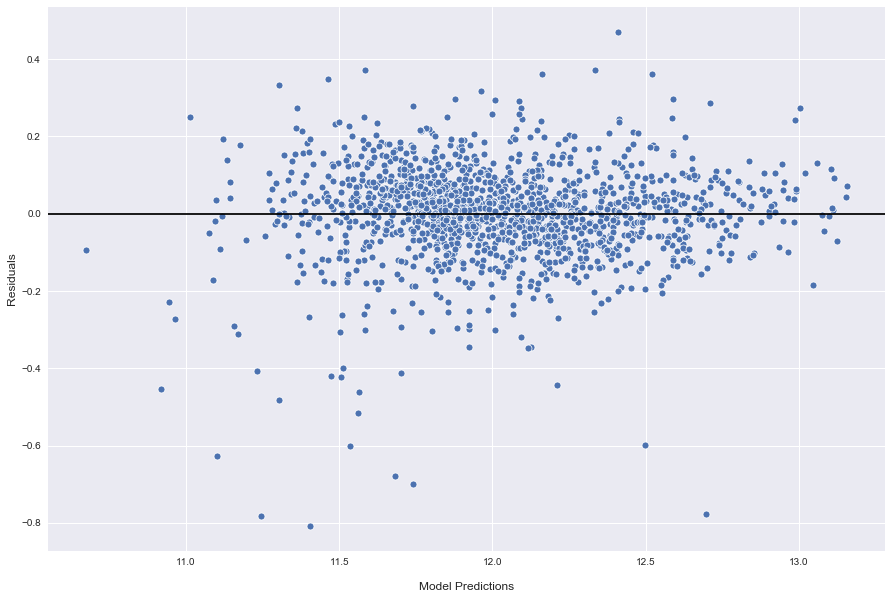

In [96]:
plt.figure(figsize=(15,10))
sns.scatterplot(lasso_preds, lasso_resids)
plt.axhline(0, color="black");
plt.ylabel("Residuals", fontsize = 12)
plt.xlabel("Model Predictions", fontsize = 12, labelpad= 15);

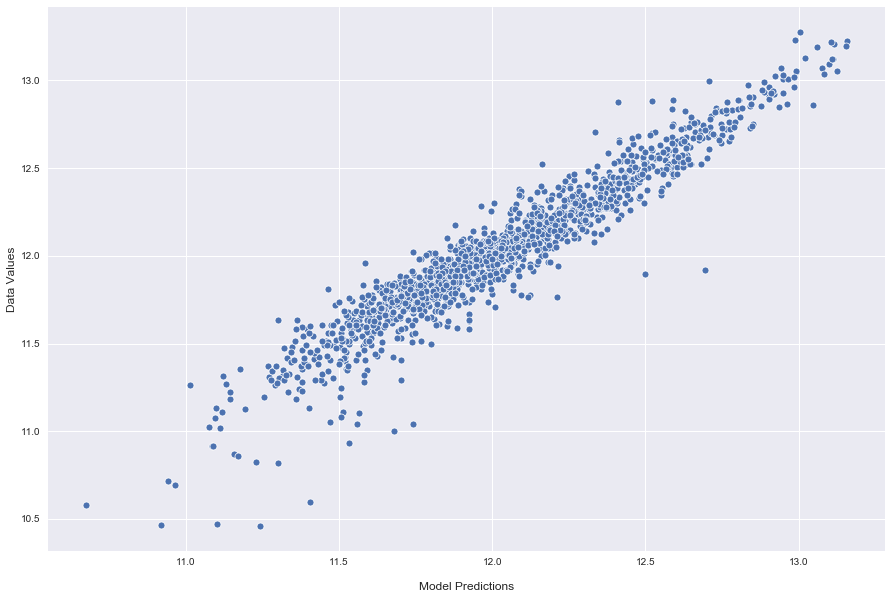

In [97]:
plt.figure(figsize=(15,10))
sns.scatterplot(lasso_preds, y_train)
# plt.axhline(0, color="black");
plt.ylabel("Data Values", fontsize = 12)
plt.xlabel("Model Predictions", fontsize = 12, labelpad= 15);

### TEST DATA Variable Manipulation

* In order to make predictions, I must manipulate the test data frame (used to predict) in the same way I did columns of interest in the training data set.

In [98]:
# reading the test data into a data frame variable master
test_data = pd.read_csv('./datasets/test.csv')

In [99]:
test_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


* Test data has all of the same columns and information, but does not have the prediction variable (price) We will need to model our train data to predict these values onto the test data set.

In [100]:
test_data.isnull().mean().sort_values(ascending = False).head(20)

Pool QC           0.995449
Misc Feature      0.953356
Alley             0.934016
Fence             0.804323
Fireplace Qu      0.480091
Lot Frontage      0.182025
Garage Cond       0.051195
Garage Qual       0.051195
Garage Yr Blt     0.051195
Garage Finish     0.051195
Garage Type       0.050057
Bsmt Exposure     0.028441
BsmtFin Type 1    0.028441
Bsmt Qual         0.028441
BsmtFin Type 2    0.028441
Bsmt Cond         0.028441
Mas Vnr Area      0.001138
Mas Vnr Type      0.001138
Electrical        0.001138
Overall Cond      0.000000
dtype: float64

In [101]:
# Need to apply same transformation to the test data for predictions.
test_data['log_Lot Area'] = test_data['Lot Area'].apply(np.log)

In [102]:
test_data.shape

(879, 81)

In [103]:
# Log transforming 1st Floor Column. For Test Data.
test_data['log_1st Flr SF'] = test_data['1st Flr SF'].apply(np.log)

In [104]:
# Recategorizing 
test_data['Bldg Type'] = test_data['Bldg Type'].map(lambda Bldg: '1Fam' if Bldg == '1Fam' else ('TwnhsE' if Bldg == 'TwnhsE' else 'Other'))
test_data['Bldg Type'].value_counts('mean')

1Fam      0.824801
Other     0.093288
TwnhsE    0.081911
Name: Bldg Type, dtype: float64

In [105]:
# Recatergorizing
test_data['MS Zoning'] = test_data['MS Zoning'].map(lambda zone: 'RL' if zone == 'RL' else ('RM' if zone == 'RM' else ('FV' if zone == 'FV' else 'Other')))
test_data['MS Zoning'].value_counts('mean')

RL       0.767918
RM       0.166098
FV       0.043231
Other    0.022753
Name: MS Zoning, dtype: float64

In [106]:
test_data['Neighborhood'] = test_data['Neighborhood'].map(lambda hood: 'CollgCr' if hood == 'CollgCr' else ('OldTown' if hood == 'OldTown' else ('Edwards' if hood == 'Edwards' else ('Somerst' if hood == 'Somerst' else ('NoRidge' if hood == 'NoRidge' else ('IDOTRR' if hood == 'IDOTRR' else ('StoneBr' if hood == 'StoneBr' else ('NridgHt' if hood == 'NridgHt' else 'Other'))))))))
test_data['Neighborhood'].value_counts('mean')

Other      0.579067
CollgCr    0.098976
OldTown    0.086462
Somerst    0.059158
Edwards    0.058020
NridgHt    0.050057
IDOTRR     0.027304
NoRidge    0.026166
StoneBr    0.014790
Name: Neighborhood, dtype: float64

* Needed to transform to have the same number of dummy Neighborhood columns as the Training data set.

In [107]:
# Recatergorizing
test_data['House Style'] = test_data['House Style'].map(lambda house: '1Story' if house == '1Story' else ('2Story' if house == '2Story' else ('1.5Fin' if house == '1.5Fin' else 'Other')))
test_data['House Style'].value_counts('mean')

1Story    0.480091
2Story    0.312856
1.5Fin    0.109215
Other     0.097838
Name: House Style, dtype: float64

In [108]:
test_data = pd.get_dummies(test_data, 
                          columns=['House Style','MS Zoning','Bldg Type','Neighborhood'], 
                          drop_first=True
                         )

In [109]:
test_data['age'] = 2019 - test_data['Year Built']

test_data['Remodel age'] = 2019 - test_data['Year Remod/Add']

### Ordinal Variables - Test Data

In [110]:
test_data['Kitchen Qual'].value_counts()

TA    447
Gd    354
Ex     54
Fa     23
Po      1
Name: Kitchen Qual, dtype: int64

In [111]:
test_data['Kitchen Qual'] = test_data['Kitchen Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [112]:
test_data['Exter Qual'] = test_data['Exter Qual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [113]:
test_data['Exter Cond'] = test_data['Exter Cond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [114]:
test_data['Heating QC'] = test_data['Heating QC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [115]:
test_data['Heating'].value_counts()

GasA     867
GasW       7
Grav       4
Floor      1
Name: Heating, dtype: int64

In [116]:
test_data['Heating'] = [1 if i == 'GasA' else 0 for i in test_data['Heating']]

In [117]:
test_data.shape

(879, 96)

In [118]:
poly_interest_ = ['log_SalePrice','Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Full Bath', 'log_Lot Area', 'TotRms AbvGrd', 'Fireplaces','2nd Flr SF','log_1st Flr SF','age', 'Garage Area', 'Remodel age','Total Bsmt SF','BsmtFin SF 1','Bsmt Unf SF','Kitchen Qual','Exter Qual','Heating QC']

In [119]:
t_features = ['Id']
t_features.extend(poly_interest[1:])

In [120]:
# Poly Test Data Set
test_poly = test_data[t_features]
test_poly.shape

(879, 19)

In [121]:
test_poly.head()

,Id,Overall Qual,Gr Liv Area,Garage Cars,Full Bath,log_Lot Area,TotRms AbvGrd,Fireplaces,2nd Flr SF,log_1st Flr SF,age,Garage Area,Remodel age,Total Bsmt SF,BsmtFin SF 1,Bsmt Unf SF,Kitchen Qual,Exter Qual,Heating QC
0,2658,6,1928,1,2,9.120634,9,0,1020,6.811244,109,440,69,1020,0,1020,2,3,4
1,2718,5,1967,2,2,9.175956,10,0,0,7.584265,42,580,42,1967,0,1967,3,3,3
2,2414,7,1496,2,2,9.747068,7,1,832,6.498282,13,426,13,654,554,100,4,4,5
3,1989,5,968,2,1,9.050172,5,0,0,6.875232,96,480,13,968,0,968,3,4,3
4,625,6,1394,2,1,9.159047,6,2,0,7.239933,56,514,56,1394,609,785,3,3,4


In [122]:
X = test_poly.drop(columns=['Id'])

In [123]:
IDs = test_poly['Id']

In [124]:
features = X.columns

In [125]:
poly = PolynomialFeatures(include_bias=False)

In [126]:
Xt_poly = poly.fit_transform(X)
Xt_poly.shape

(879, 189)

In [127]:
poly_cols = poly.get_feature_names(features)

In [128]:
x_test_scale = ss.transform(Xt_poly)

* Because I scaled the training data set for the Lasso Model, I need to peform the same scaling to the test data.

In [129]:
# x_test_scale

In [130]:
# zip allows us to combine two lists together
predict_dict = dict(zip(IDs, lasso.predict(x_test_scale)))

### Kaggle Submission

In [131]:
# # Lasso Model 
predict_df = pd.DataFrame(predict_dict.items(), columns=['Id','SalePrice'])
predict_df['SalePrice'] = predict_df['SalePrice'].apply(np.exp)
predict_df[['Id', 'SalePrice']].head()

,Id,SalePrice
0,2658,128977.140886
1,2718,157345.151577
2,2414,207833.893520
3,1989,115776.997160
4,625,171845.096194


In [132]:
# Saving predictions to csv file.
predict_df[['Id', 'SalePrice']].to_csv('./datasets/predictions/final.csv', index=False)